# Data Processing pipeline test II

## Specific Test II. Lens Finding

- Task: Build a model identifying lenses using PyTorch or Keras. For the training use the images in train_lenses and train_nonlenses directories, for evaluation use the images from test_lenses and test_nonlenses directories. Note that the number of non-lenses is much larger than the number of lensed galaxies. Pick the most appropriate approach and discuss your strategy.

- Dataset Description: A dataset comprising observational data of strong lenses and non-lensed galaxies. Images in three different filters are available for each object, so the shape of each object array is (3, 64, 64). Lensed objects are placed in the directory train_lenses and test_lenses, non-lensed galaxies are in train_nonlenses and test_nonlenses.

- Evaluation Metrics: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

## Downloading the data

In [1]:
# import os
# import gdown
# import zipfile

# # Define the Google Drive file ID and output filename
# file_id = "1doUhVoq1-c9pamZVLpvjW1YRDMkKO1Q5"
# output_file = "dataset.zip"

# # Download the file using gdown
# gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output_file, quiet=False)

# # Create a directory for extraction
# extract_dir = "dataset"
# os.makedirs(extract_dir, exist_ok=True)

# # Unzip the file
# try:
#     with zipfile.ZipFile(output_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)
#     print("Extraction successful!")
# except zipfile.BadZipFile:
#     print("Error: The downloaded file is not a valid ZIP file.")

# # List extracted files
# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)


## My Approach - 

- Visualize the dataset and understand the imbalance in dataset classes.
- As usual, we start with establishing baselines for the given dataset, using Res-Net18 CNN backbone.
- Even after having imbalanced dataset, we observe that the ROC and AUC of the model is pretty good.
- To understand this surprising results, we also perform the same interpretability grad cam experiments which, help us to visualize what the model is focusing on, in both correctly and incorrrectly classified examples, giving a lens for us to understand, what and why is the model thinking for doing classification.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def load_npy_file(file_path):
    return np.load(file_path)


def display_image(image_array, title=""):
    plt.imshow(image_array.transpose(1, 2, 0))  # Transpose to (64, 64, 3) for RGB display
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
train_lenses_dir = 'dataset/train_lenses'
train_nonlenses_dir = 'dataset/train_nonlenses'

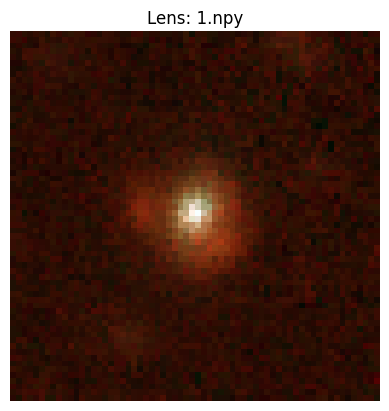

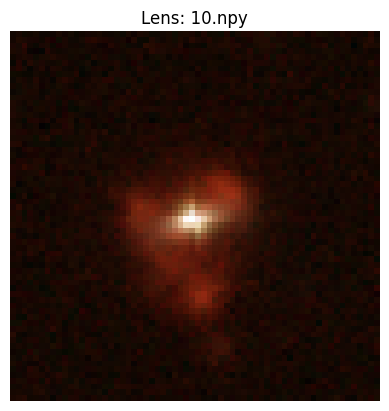

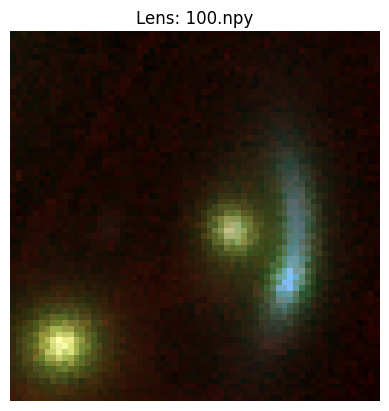

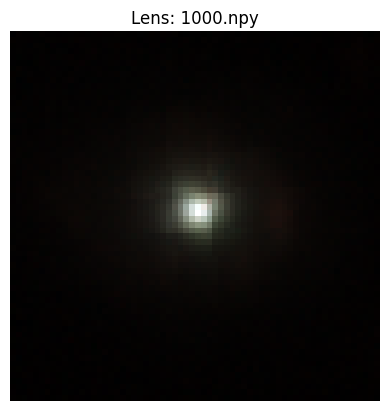

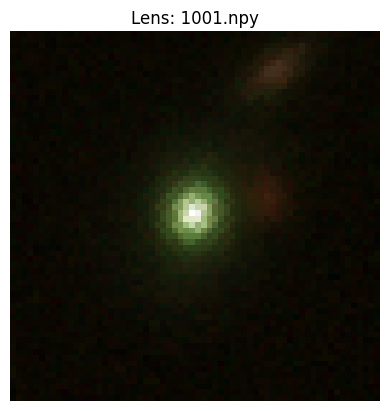

In [5]:
lens_files = [f for f in os.listdir(train_lenses_dir) if f.endswith('.npy')]
for file_name in lens_files[:5]:  # Display first 5 lens images
    file_path = os.path.join(train_lenses_dir, file_name)
    image_array = load_npy_file(file_path)
    display_image(image_array, title=f"Lens: {file_name}")


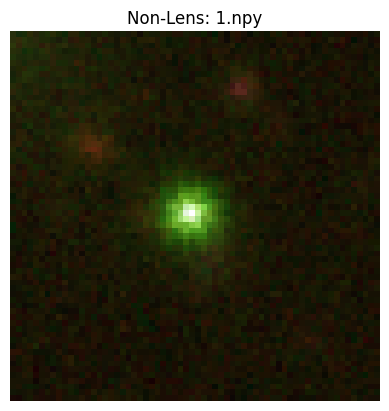

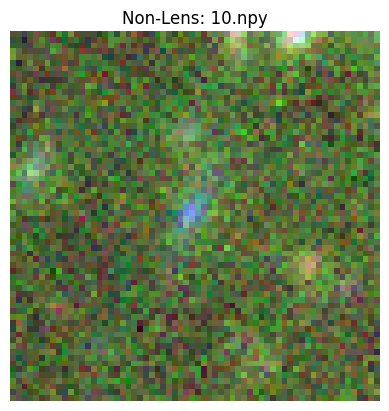

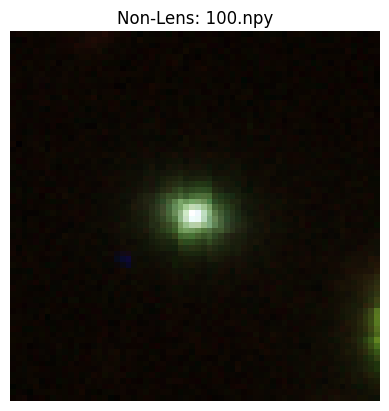

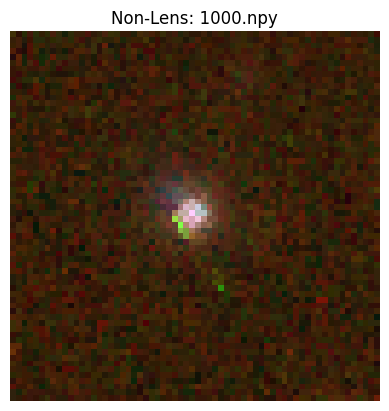

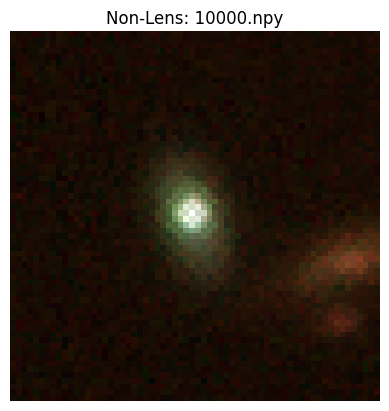

In [6]:
nonlens_files = [f for f in os.listdir(train_nonlenses_dir) if f.endswith('.npy')]
for file_name in nonlens_files[:5]:  # Display first 5 non-lens images
    file_path = os.path.join(train_nonlenses_dir, file_name)
    image_array = load_npy_file(file_path)
    display_image(image_array, title=f"Non-Lens: {file_name}")


In [7]:
print("Number of lens images:", len(lens_files))
print("Number of non-lens images:", len(nonlens_files))
print("Image shape:", image_array.shape)

Number of lens images: 1730
Number of non-lens images: 28675
Image shape: (3, 64, 64)


## Establishing baseline

In [8]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models


In [17]:
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Load lens and non-lens files
        lens_dir = os.path.join(root_dir, "train_lenses")
        nonlens_dir = os.path.join(root_dir, "train_nonlenses")

        lens_files = [os.path.join(lens_dir, f) for f in os.listdir(lens_dir) if f.endswith(".npy")]
        nonlens_files = [os.path.join(nonlens_dir, f) for f in os.listdir(nonlens_dir) if f.endswith(".npy")]

        # Assign labels: 1 = Lens, 0 = Non-lens
        self.samples.extend([(f, 1) for f in lens_files])
        self.samples.extend([(f, 0) for f in nonlens_files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        image = np.load(file_path)  # Load .npy file

        if image.shape[0] == 3:
            image = torch.tensor(image, dtype=torch.float32)  # Convert to tensor (3, 64, 64)

        if self.transform:
            image = self.transform(image)  # Apply transformations (but not ToTensor)

        return image, label


In [ ]:
train_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Only normalize
])

val_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [19]:
# Define dataset paths
train_dir = "dataset"
test_dir = "dataset"

# Load datasets
train_dataset = LensDataset(root_dir=train_dir, transform=train_transforms)
val_dataset = LensDataset(root_dir=test_dir, transform=val_transforms)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check dataset size
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 30405, Validation samples: 30405


In [20]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to match (3, 64, 64) input
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Modify the last fully connected (FC) layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Output = 2 classes (Lens, Non-Lens)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [21]:
criterion = nn.CrossEntropyLoss()  # No class weights yet, will add later, because it is needed to handle class imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print("Training Complete!")

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


| class    | dataset percentage |
| -------- | ------- |
| lenses  | 5.7 %    |
| non lenses | 94.3%    |


In [23]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 0.1370, Train Acc: 94.62%, Val Acc: 95.07%
Epoch 2/10, Train Loss: 0.1119, Train Acc: 95.73%, Val Acc: 95.86%
Epoch 3/10, Train Loss: 0.1001, Train Acc: 96.12%, Val Acc: 96.43%
Epoch 4/10, Train Loss: 0.1225, Train Acc: 95.30%, Val Acc: 95.90%
Epoch 5/10, Train Loss: 0.0963, Train Acc: 96.32%, Val Acc: 97.03%
Epoch 6/10, Train Loss: 0.0825, Train Acc: 96.81%, Val Acc: 97.10%
Epoch 7/10, Train Loss: 0.0767, Train Acc: 97.00%, Val Acc: 96.63%
Epoch 8/10, Train Loss: 0.0679, Train Acc: 97.38%, Val Acc: 97.41%
Epoch 9/10, Train Loss: 0.0626, Train Acc: 97.62%, Val Acc: 98.01%
Epoch 10/10, Train Loss: 0.0549, Train Acc: 97.96%, Val Acc: 98.05%
Training Complete!


In [24]:
from sklearn.metrics import roc_auc_score

def evaluate_with_auc(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of "lens"

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_preds)
    print(f"Validation AUC: {auc:.4f}")
    return auc

# Compute AUC Score
evaluate_with_auc(model, val_loader)


Validation AUC: 0.9903


0.9902724876657376

understanding/interpreting this highly unusual accuracy and AUC for imbalanced dataset


In [25]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [26]:
# Define test dataset paths
test_lens_dir = "dataset/test_lenses"
test_nonlens_dir = "dataset/test_nonlenses"

# Get 3 random lens images
lens_files = [os.path.join(test_lens_dir, f) for f in os.listdir(test_lens_dir) if f.endswith(".npy")]
nonlens_files = [os.path.join(test_nonlens_dir, f) for f in os.listdir(test_nonlens_dir) if f.endswith(".npy")]

# Select 3 samples from each category
sample_lenses = lens_files[:3]
sample_nonlenses = nonlens_files[:3]


In [27]:
# Image normalization (same as during training)
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

def preprocess_image(file_path):
    """Loads an .npy image and preprocesses it for the model."""
    image = np.load(file_path)
    
    # Convert to tensor
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # Normalize
    image_tensor = normalize(image_tensor)
    
    # Add batch & channel dimension (B, C, H, W)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    return image, image_tensor


In [28]:
from pytorch_grad_cam import GradCAM

# Define target layer (ResNet's last convolutional layer)
target_layer = model.layer4[-1]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])


In [29]:
def generate_gradcam(image_tensor, image_original, target_class):
    """Computes Grad-CAM heatmap and overlays it on the original image."""
    targets = [ClassifierOutputTarget(target_class)]  # Target class (0=non-lens, 1=lens)
    
    # Generate Grad-CAM heatmap
    grayscale_cam = cam(image_tensor, targets)[0]

    # Convert grayscale image to RGB (3-channel)
    image_rgb = np.transpose(image_original, (1, 2, 0))  # Convert (3, 64, 64) → (64, 64, 3)
    image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min())  # Normalize for visualization

    # Overlay heatmap onto original image
    heatmap = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)

    return heatmap


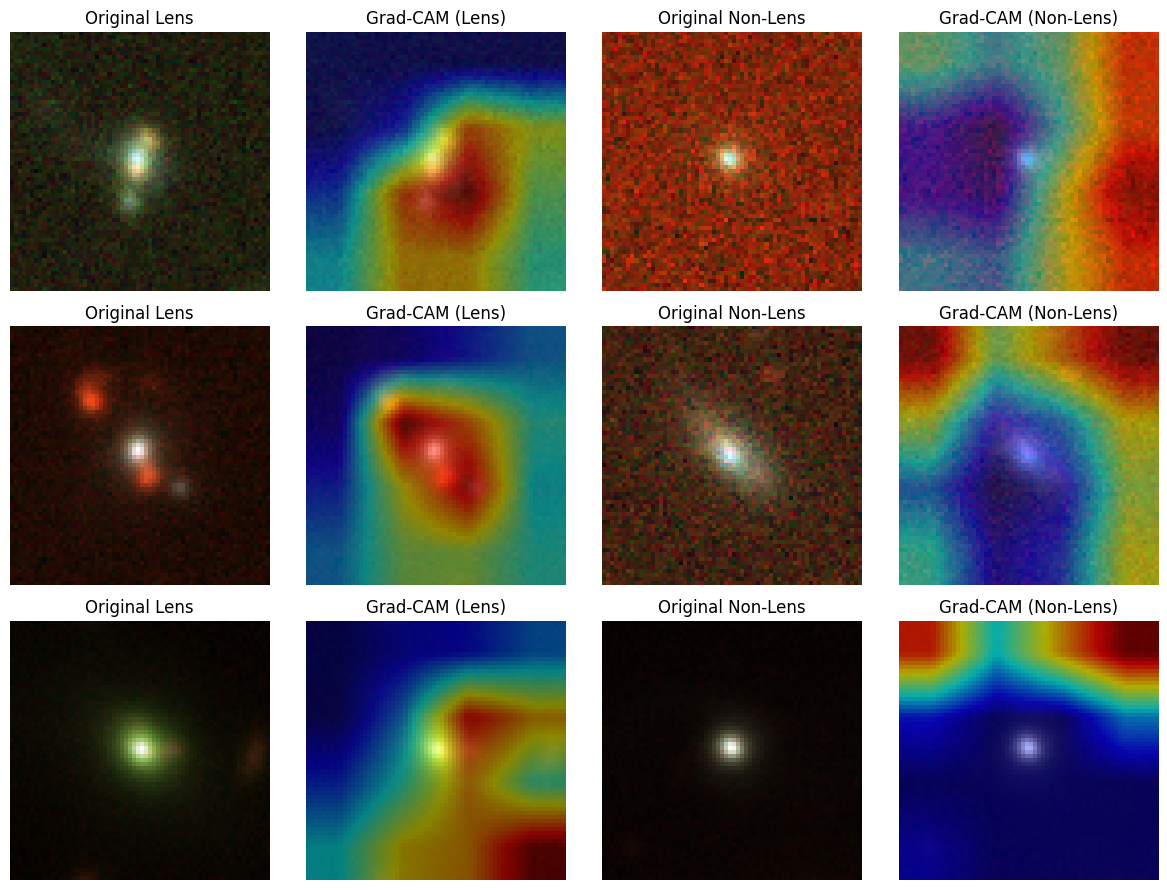

In [30]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Process 3 lens images
for i, lens_file in enumerate(sample_lenses):
    orig_image, tensor_image = preprocess_image(lens_file)
    gradcam_image = generate_gradcam(tensor_image, orig_image, target_class=1)  # Target = Lens

    axes[i, 0].imshow(np.transpose(orig_image, (1, 2, 0)))  # Convert (3,64,64) -> (64,64,3)
    axes[i, 0].set_title("Original Lens")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(gradcam_image)
    axes[i, 1].set_title("Grad-CAM (Lens)")
    axes[i, 1].axis("off")

# Process 3 non-lens images
for i, nonlens_file in enumerate(sample_nonlenses):
    orig_image, tensor_image = preprocess_image(nonlens_file)
    gradcam_image = generate_gradcam(tensor_image, orig_image, target_class=0)  # Target = Non-Lens

    axes[i, 2].imshow(np.transpose(orig_image, (1, 2, 0)))  # Convert (3,64,64) -> (64,64,3)
    axes[i, 2].set_title("Original Non-Lens")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(gradcam_image)
    axes[i, 3].set_title("Grad-CAM (Non-Lens)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()


In [31]:
def find_misclassified_images(model, val_loader, num_samples=3):
    """
    Finds misclassified lens and non-lens images.
    """
    model.eval()
    misclassified_lenses = []  # Should be lenses but misclassified as non-lenses
    misclassified_nonlenses = []  # Should be non-lenses but misclassified as lenses
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:  # Misclassification
                    image = images[i].cpu().numpy()  # Convert tensor to NumPy array
                    
                    if labels[i] == 1 and len(misclassified_lenses) < num_samples:
                        misclassified_lenses.append((image, labels[i].item(), preds[i].item()))
                    elif labels[i] == 0 and len(misclassified_nonlenses) < num_samples:
                        misclassified_nonlenses.append((image, labels[i].item(), preds[i].item()))

                if len(misclassified_lenses) >= num_samples and len(misclassified_nonlenses) >= num_samples:
                    break  # Stop if we have enough misclassified samples

    return misclassified_lenses, misclassified_nonlenses


In [32]:
def generate_gradcam_on_misclassified(image, true_label, predicted_label):
    """
    Generates Grad-CAM heatmap for a misclassified image.
    """
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)  # Convert to tensor

    targets = [ClassifierOutputTarget(predicted_label)]  # Predicted class
    grayscale_cam = cam(image_tensor, targets)[0]  # Compute Grad-CAM heatmap

    # Convert grayscale image to RGB
    image_rgb = np.transpose(image, (1, 2, 0))  # Convert (3, 64, 64) → (64, 64, 3)
    image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min())  # Normalize

    # Overlay Grad-CAM heatmap
    heatmap = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)

    return heatmap


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


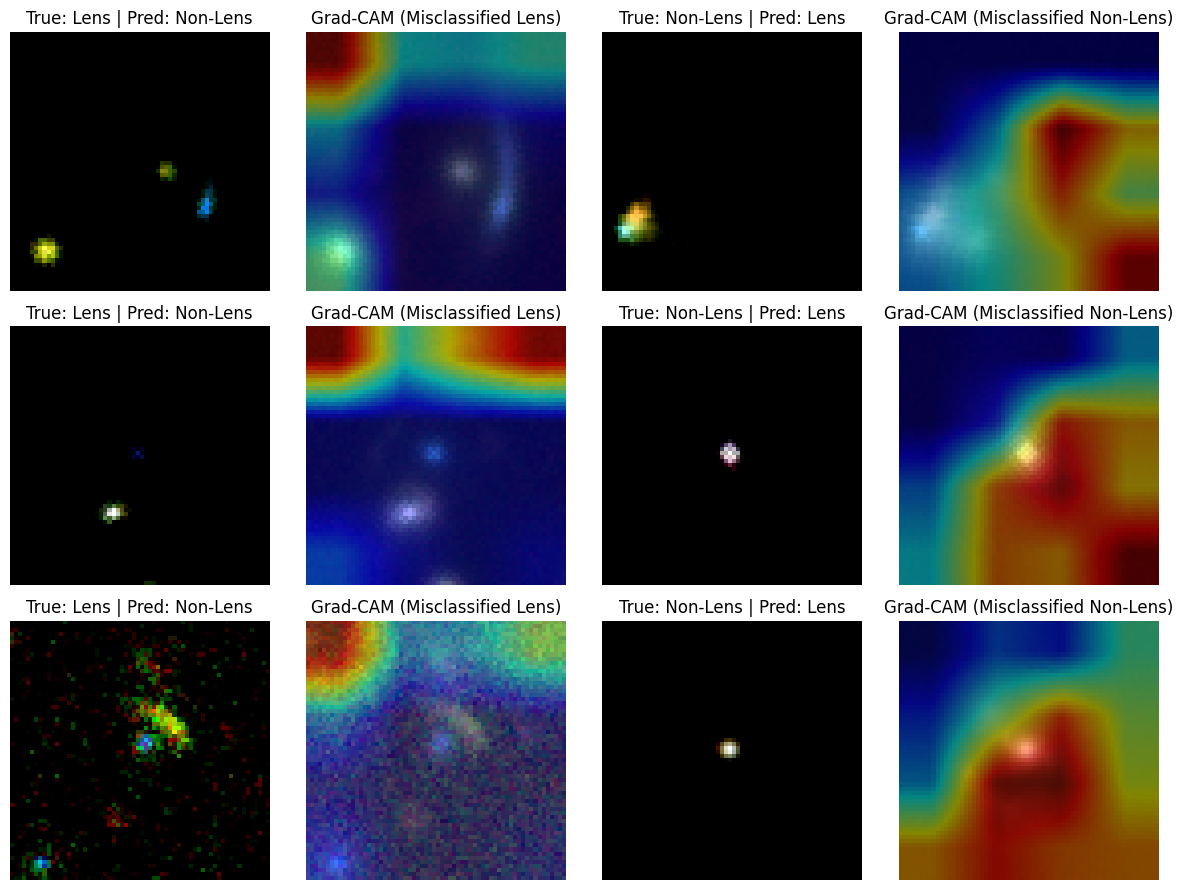

In [34]:
# Find misclassified images
misclassified_lenses, misclassified_nonlenses = find_misclassified_images(model, val_loader, num_samples=3)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Visualize misclassified lenses
for i, (image, true_label, pred_label) in enumerate(misclassified_lenses):
    heatmap = generate_gradcam_on_misclassified(image, true_label, pred_label)

    axes[i, 0].imshow(np.transpose(image, (1, 2, 0)))
    axes[i, 0].set_title(f"True: Lens | Pred: Non-Lens")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(heatmap)
    axes[i, 1].set_title("Grad-CAM (Misclassified Lens)")
    axes[i, 1].axis("off")

# Visualize misclassified non-lenses
for i, (image, true_label, pred_label) in enumerate(misclassified_nonlenses):
    heatmap = generate_gradcam_on_misclassified(image, true_label, pred_label)

    axes[i, 2].imshow(np.transpose(image, (1, 2, 0)))
    axes[i, 2].set_title(f"True: Non-Lens | Pred: Lens")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(heatmap)
    axes[i, 3].set_title("Grad-CAM (Misclassified Non-Lens)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()
